In [1]:
# I am just practicing things based on the following sources:
# 
# Video Tutorial: https://www.youtube.com/watch?v=VMj-3S1tku0
# GitHub repo: https://github.com/karpathy/micrograd

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self.label = label
        self._op = _op
        self.grad = 0
        
    def __add__(self, other):
        return Value(self.data + other.data, _children=(self, other), _op='+')
    
    def __mul__(self, other):
        return Value(self.data * other.data, _children=(self, other), _op='*')
        
    def __repr__(self):
        return f'Value(label={self.label}, data={self.data})'

In [4]:
a = Value(2.0, label='a'); print(a)
b = Value(-3.0, label='b'); print(b)
c = a * b; c.label='c'; print(c)
d = Value(2.0, label='d'); print(d)
e = c + d; e.label='e'; print(e)
f = Value(2.0, label='f'); print(f)
L = e * f; L.label='L'; print(L)

Value(label=a, data=2.0)
Value(label=b, data=-3.0)
Value(label=c, data=-6.0)
Value(label=d, data=2.0)
Value(label=e, data=-4.0)
Value(label=f, data=2.0)
Value(label=L, data=-8.0)


In [5]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
                
    build(root)
    return nodes,edges
    
def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "%s | data %.4f | grad %.4f" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name = uid + n._op, label= f"{n._op}")
            
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
            
    return dot
    

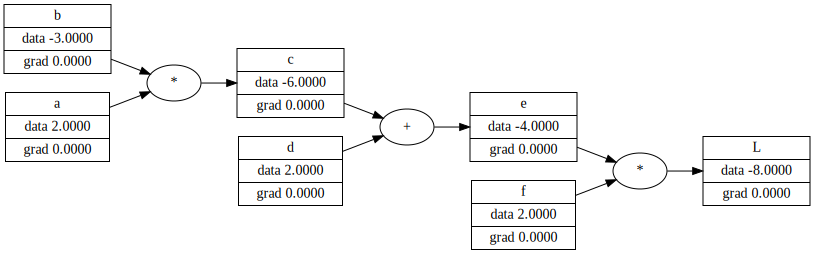

In [6]:
draw_dot(L)

In [7]:
h = 0.01

In [8]:
def fn(a,b,d,f):
    c = a * b
    e = c + d
    L = e * f
    return L.data

In [9]:
dL_dL = ((fn(a,b,d,f) + h) - fn(a,b,d,f))/h
L.grad = dL_dL

In [10]:
f.grad = e.data
e.grad = f.data

d.grad = e.grad * L.grad
c.grad = e.grad * L.grad

b.grad = c.grad * a.data
a.grad = c.grad * b.data

In [11]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
d.data += 0.01 * d.grad
f.data += 0.01 * f.grad

In [12]:
c = a * b; c.label='c'
e = c + d; e.label='e'; print(e)
L = e * f; L.label='L'; print(L)

Value(label=e, data=-3.7224000000000057)
Value(label=L, data=-7.295904000000011)


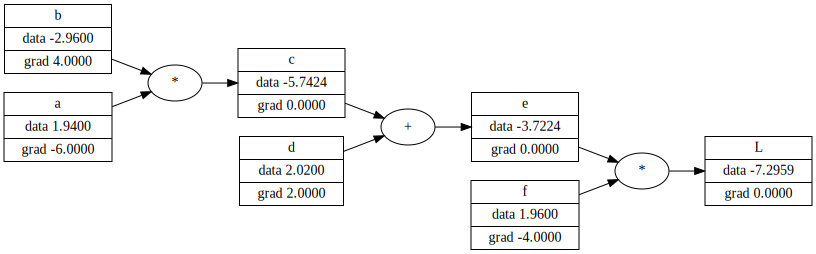

In [13]:
draw_dot(L)

In [14]:
class Value_Full:
    
    def __init__(self, data, label="", _children=(), _op=None):
        self.data = data
        self.grad = 0
        self.label = label
        self._prev = set(_children)
        self._op = _op
        self._backward = lambda: None
    
    def __add__(self, other):
        other = other if isinstance(other, Value_Full) else Value_Full(other)
        out = Value_Full(self.data + other.data, _children=(self, other), _op="+")
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
            
        out._backward = _backward

        return out

    def __radd__(self, other):
        return self + other
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)

    def __mul__(self, other, _op="*"):
        other = other if isinstance(other, Value_Full) else Value_Full(other)
        out = Value_Full(self.data * other.data, _children=(self, other), _op="*")
        
        def _backward():
            self.grad += (other.data * out.grad)
            other.grad += (self.data * out.grad)
            
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def exp(self):
        x = self.data
        out = Value_Full(math.exp(x), _children=(self,), _op="exp")
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
        
    def __truediv__(self, other):
        return self * (other**-1)
    
    def __pow__(self, other):
        assert isinstance(other,(int,float)), "only supporting int/float pow"
        out = Value_Full(self.data**other, _children=(self,), _op=f'**{other}')
        
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value_Full(t, _children=(self, ), _op="tanh")
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        
        out._backward = _backward
        return out
    
    def backward(self):
        # build a topological graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        # call backwards in the topological order
        self.grad = 1.0

        for node in reversed(topo):
            node._backward()
    
    def __repr__(self):
        return f'V{self.label}[d:{self.data:4f} | grad:{self.grad}]'

In [15]:
a = Value_Full(1.2)
a

V[d:1.200000 | grad:0]

In [16]:
def reset_grads():
    global x1,x2,w1,w2,b,w1x1,w2x2,w1x1w2x2,n,o
    # inputs x1,x2
    x1 = Value_Full(2.0, label='x1')
    x2 = Value_Full(0.0, label='x2')

    # wights w1,w2
    w1 = Value_Full(-3.0, label='w1')
    w2 = Value_Full(1.0, label='w2')

    # bias of the neuron
    b = Value_Full(6.8813735870195432, label='b')

    # n = x1*w1 + x2*w2 + b
    w1x1 = x1*w1; w1x1.label = 'x1w1'
    w2x2 = x2*w2; w2x2.label = 'x1w2'
    w1x1w2x2 = w1x1 + w2x2; w1x1w2x2.label = 'w1x1 + w2x2'
    n = w1x1w2x2 + b; n.label = 'n'

    # activation function tanh
    o = n.tanh(); o.label = 'o'

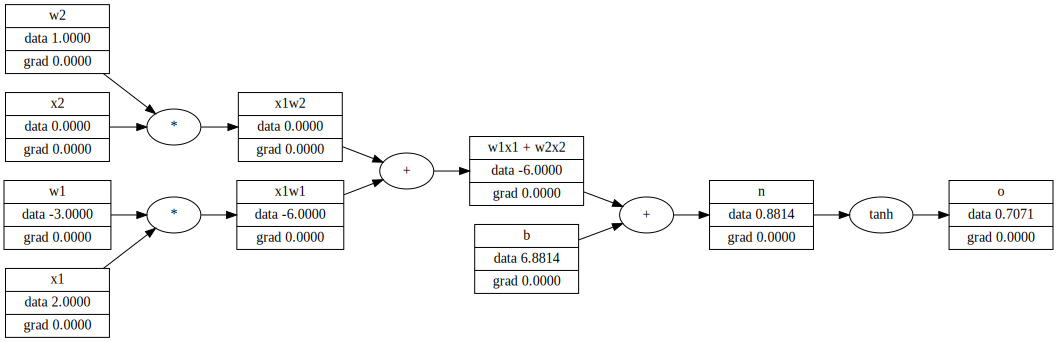

In [17]:
reset_grads()
draw_dot(o)

In [18]:
o.grad = 1.0

In [19]:
o._backward()

In [20]:
n._backward()

In [21]:
b._backward()

In [22]:
w1x1w2x2._backward()

In [23]:
w2x2._backward()

In [24]:
w1x1._backward()

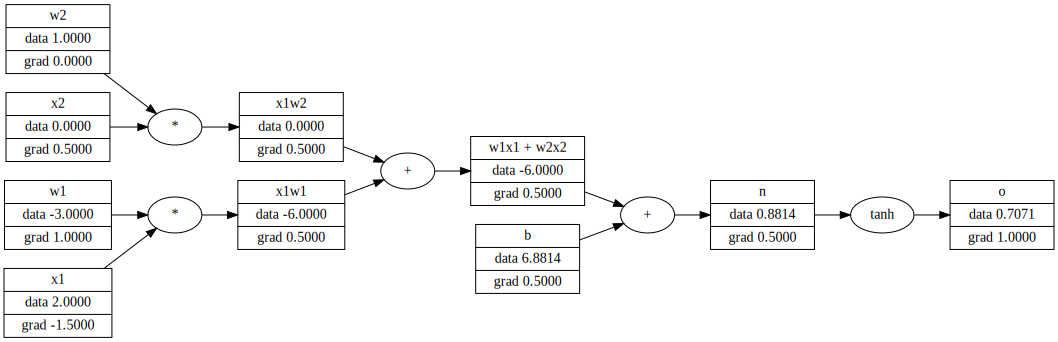

In [25]:
draw_dot(o)

In [26]:
reset_grads()
# build a topological graph
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Vx1[d:2.000000 | grad:0],
 Vw1[d:-3.000000 | grad:0],
 Vx1w1[d:-6.000000 | grad:0],
 Vw2[d:1.000000 | grad:0],
 Vx2[d:0.000000 | grad:0],
 Vx1w2[d:0.000000 | grad:0],
 Vw1x1 + w2x2[d:-6.000000 | grad:0],
 Vb[d:6.881374 | grad:0],
 Vn[d:0.881374 | grad:0],
 Vo[d:0.707107 | grad:0]]

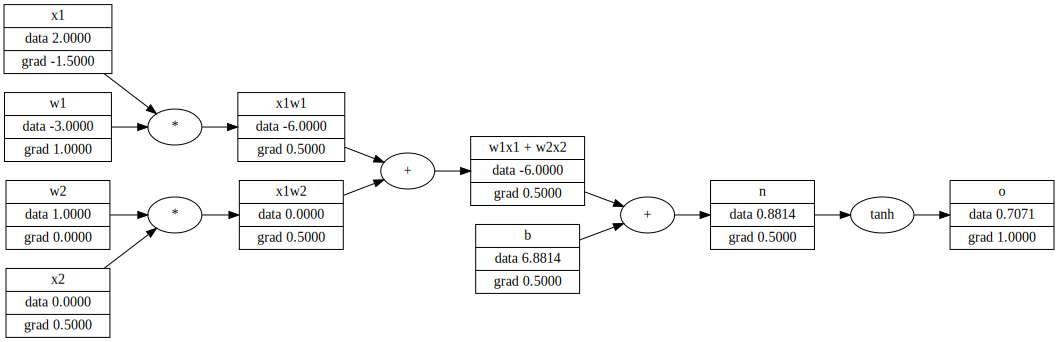

In [27]:
# call backwards in the topological order
o.grad = 1.0

for node in reversed(topo):
    node._backward()
draw_dot(o)

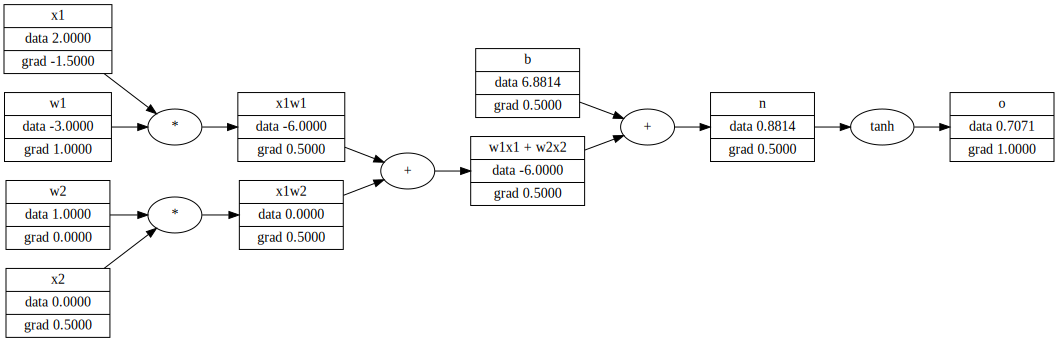

In [28]:
reset_grads()
o.backward()
draw_dot(o)

In [29]:
def reset_grads_with_tanh():
    global x1,x2,w1,w2,b,w1x1,w2x2,w1x1w2x2,n,e,o
    reset_grads()
    e = (2*n).exp(); e.label='e'
    o = (e - 1) / (e + 1); o.label='o'
    

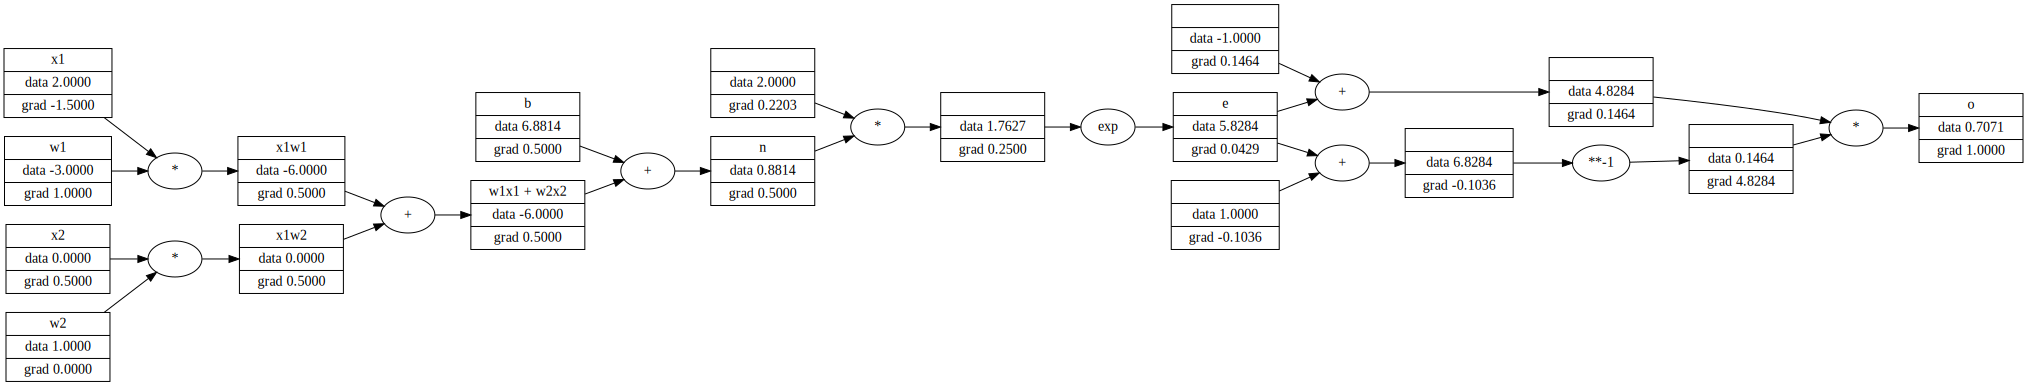

In [30]:
reset_grads_with_tanh()
o.backward()
draw_dot(o)

In [31]:
# Do the same in pytorch
# !pip install torch
import torch

In [32]:
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True

In [33]:
n = x1*w1 + x2*w2 + b
n

tensor([0.8814], dtype=torch.float64, grad_fn=<AddBackward0>)

In [34]:
o = torch.tanh(n)
o

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

In [35]:
o.backward()

In [36]:
print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [37]:
o.item()

0.7071066904050358

In [38]:
# Example of NN with python
reset_grads()

In [39]:
import random
class Neuron:
    """
    Example class that simulates a neuron with weight and bias
    """
    def __init__(self, inputs, index=1, layer_index=1):
        self.index = index
        self.w = [Value_Full(random.uniform(-1,1), label=f"w{i+1}_{layer_index}-{index}") for i in range(inputs)]
        self.b = Value_Full(random.uniform(-1,1), label=f"b_{layer_index}-{index}")
        
    def __call__(self, x):
        # x * w + b
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b) 
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
    def __repr__(self):
        lw = [wi.label for wi in self.w]
        return f"\nNeuron {self.index} [w=({', '.join(lw)}), b={self.b.label}]"

V[d:-0.988628 | grad:0]

Neuron 1 [w=(w1_1-1, w2_1-1, w3_1-1), b=b_1-1]


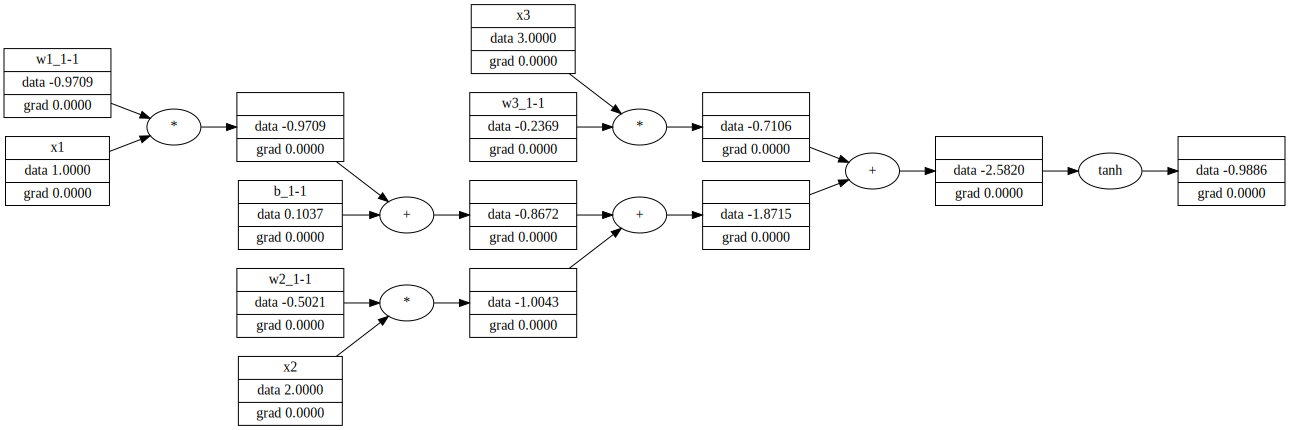

In [40]:
# Building a neuron with 3 inputs (and 1 output)
x = [1.0,2.0,3.0]
xn = [Value_Full(xi, label=f"x{i+1}") for i,xi in enumerate(x)]
n = Neuron(3)
print(n(xn))
print(n)
draw_dot(n(xn))

In [41]:
class Layer:
    """
    Example class of a layer of Neurons
    """
    def __init__(self, n_inputs, n_output, layer_index=1):
        self.layer_index = layer_index
        self.neurons = [Neuron(n_inputs, i+1, layer_index) for i in range(n_output)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
    def __repr__(self):
        return f"\n\nLayer {self.layer_index}[{self.neurons}]"
    
    

In [42]:
class MLP:
    """
    Example class of a Multilayer Perceptron (list of layers interconnected)
    """
    def __init__(self, n_inputs, n_outputs):
        sz = [n_inputs] + n_outputs
        self.layers = [Layer(sz[i], sz[i+1], i+1) for i in range(len(n_outputs))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    
    def __repr__(self):
        return f"\nMLP[{self.layers}]\n"

In [43]:
x = [2.0, 1.0, -1.0]
xn = [Value_Full(xi, label=f"x{i+1}") for i, xi in enumerate(x)]
n = MLP(3, [4, 4, 1])

print(f"MLP n has {len(n.parameters())} parameters")
print(f"Forward calc is: {n(xn)}")
n

MLP n has 41 parameters
Forward calc is: V[d:0.909531 | grad:0]



MLP[[

Layer 1[[
Neuron 1 [w=(w1_1-1, w2_1-1, w3_1-1), b=b_1-1], 
Neuron 2 [w=(w1_1-2, w2_1-2, w3_1-2), b=b_1-2], 
Neuron 3 [w=(w1_1-3, w2_1-3, w3_1-3), b=b_1-3], 
Neuron 4 [w=(w1_1-4, w2_1-4, w3_1-4), b=b_1-4]]], 

Layer 2[[
Neuron 1 [w=(w1_2-1, w2_2-1, w3_2-1, w4_2-1), b=b_2-1], 
Neuron 2 [w=(w1_2-2, w2_2-2, w3_2-2, w4_2-2), b=b_2-2], 
Neuron 3 [w=(w1_2-3, w2_2-3, w3_2-3, w4_2-3), b=b_2-3], 
Neuron 4 [w=(w1_2-4, w2_2-4, w3_2-4, w4_2-4), b=b_2-4]]], 

Layer 3[[
Neuron 1 [w=(w1_3-1, w2_3-1, w3_3-1, w4_3-1), b=b_3-1]]]]]

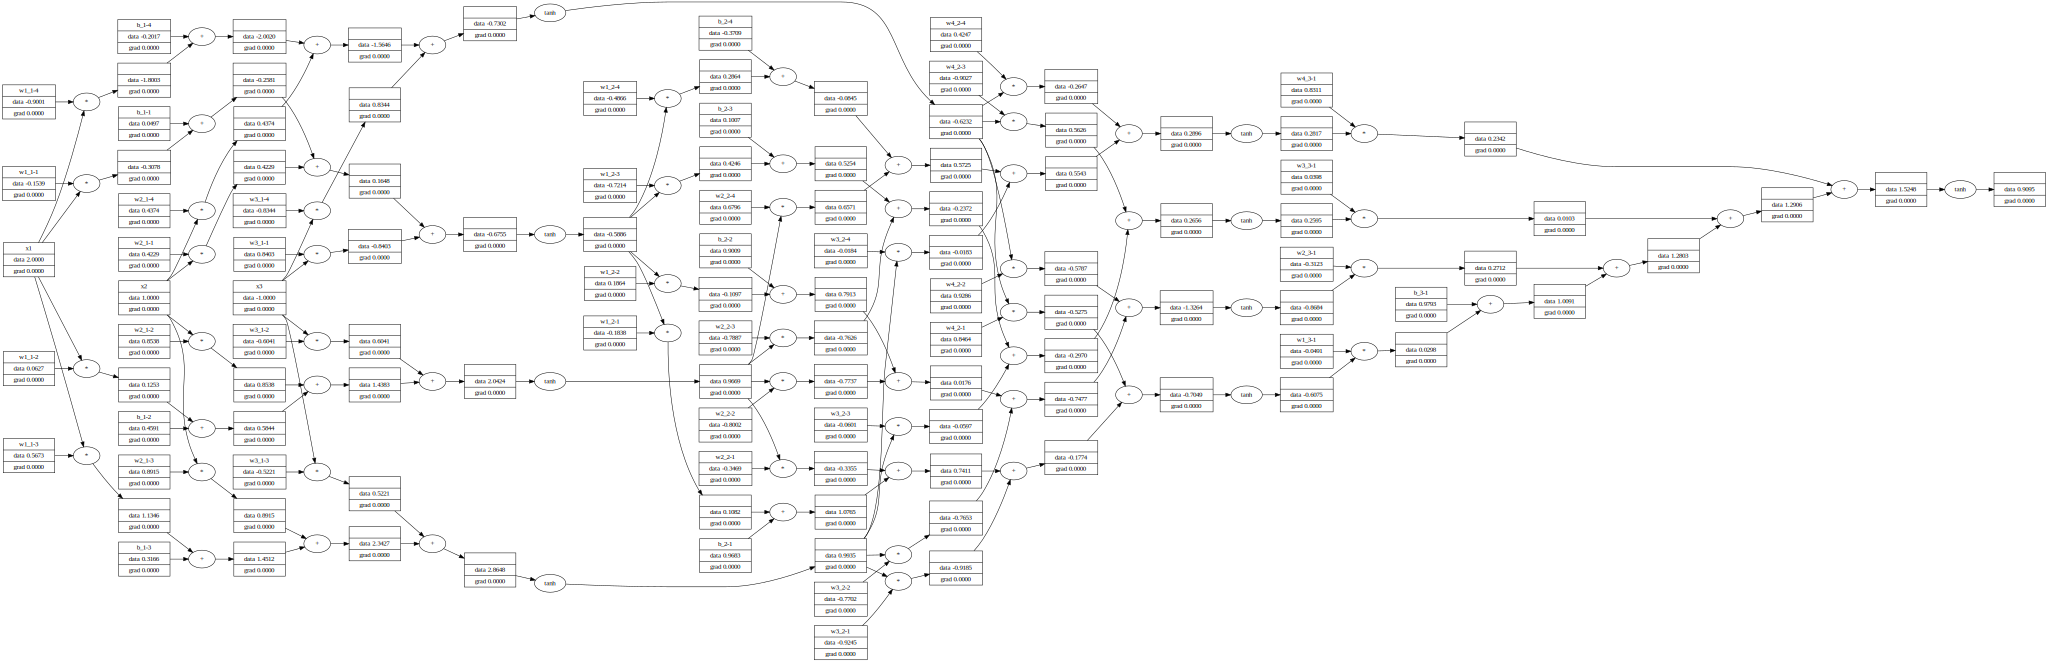

In [44]:
draw_dot(n(xn))

In [45]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0] # Targets

In [46]:
def calc_loss(n, xs, ys):
    yprod = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, yprod))
    
    return yprod,loss

In [47]:
yprod, loss = calc_loss(n, xs, ys)

In [48]:
yprod

[V[d:0.867361 | grad:0],
 V[d:0.462664 | grad:0],
 V[d:0.600028 | grad:0],
 V[d:0.913504 | grad:0]]

In [49]:
# calculate the loss
loss

V[d:4.724549 | grad:0]

In [50]:
# minimize the loss
for p in n.parameters():
    p.grad = 0.0 # Set grad to 0
loss.backward()

In [51]:
n.layers[0].neurons[0].w[0]

Vw1_1-1[d:-0.153899 | grad:-1.4136807156566729]

In [52]:
n.layers[0].neurons[0].w[0].grad

-1.4136807156566729

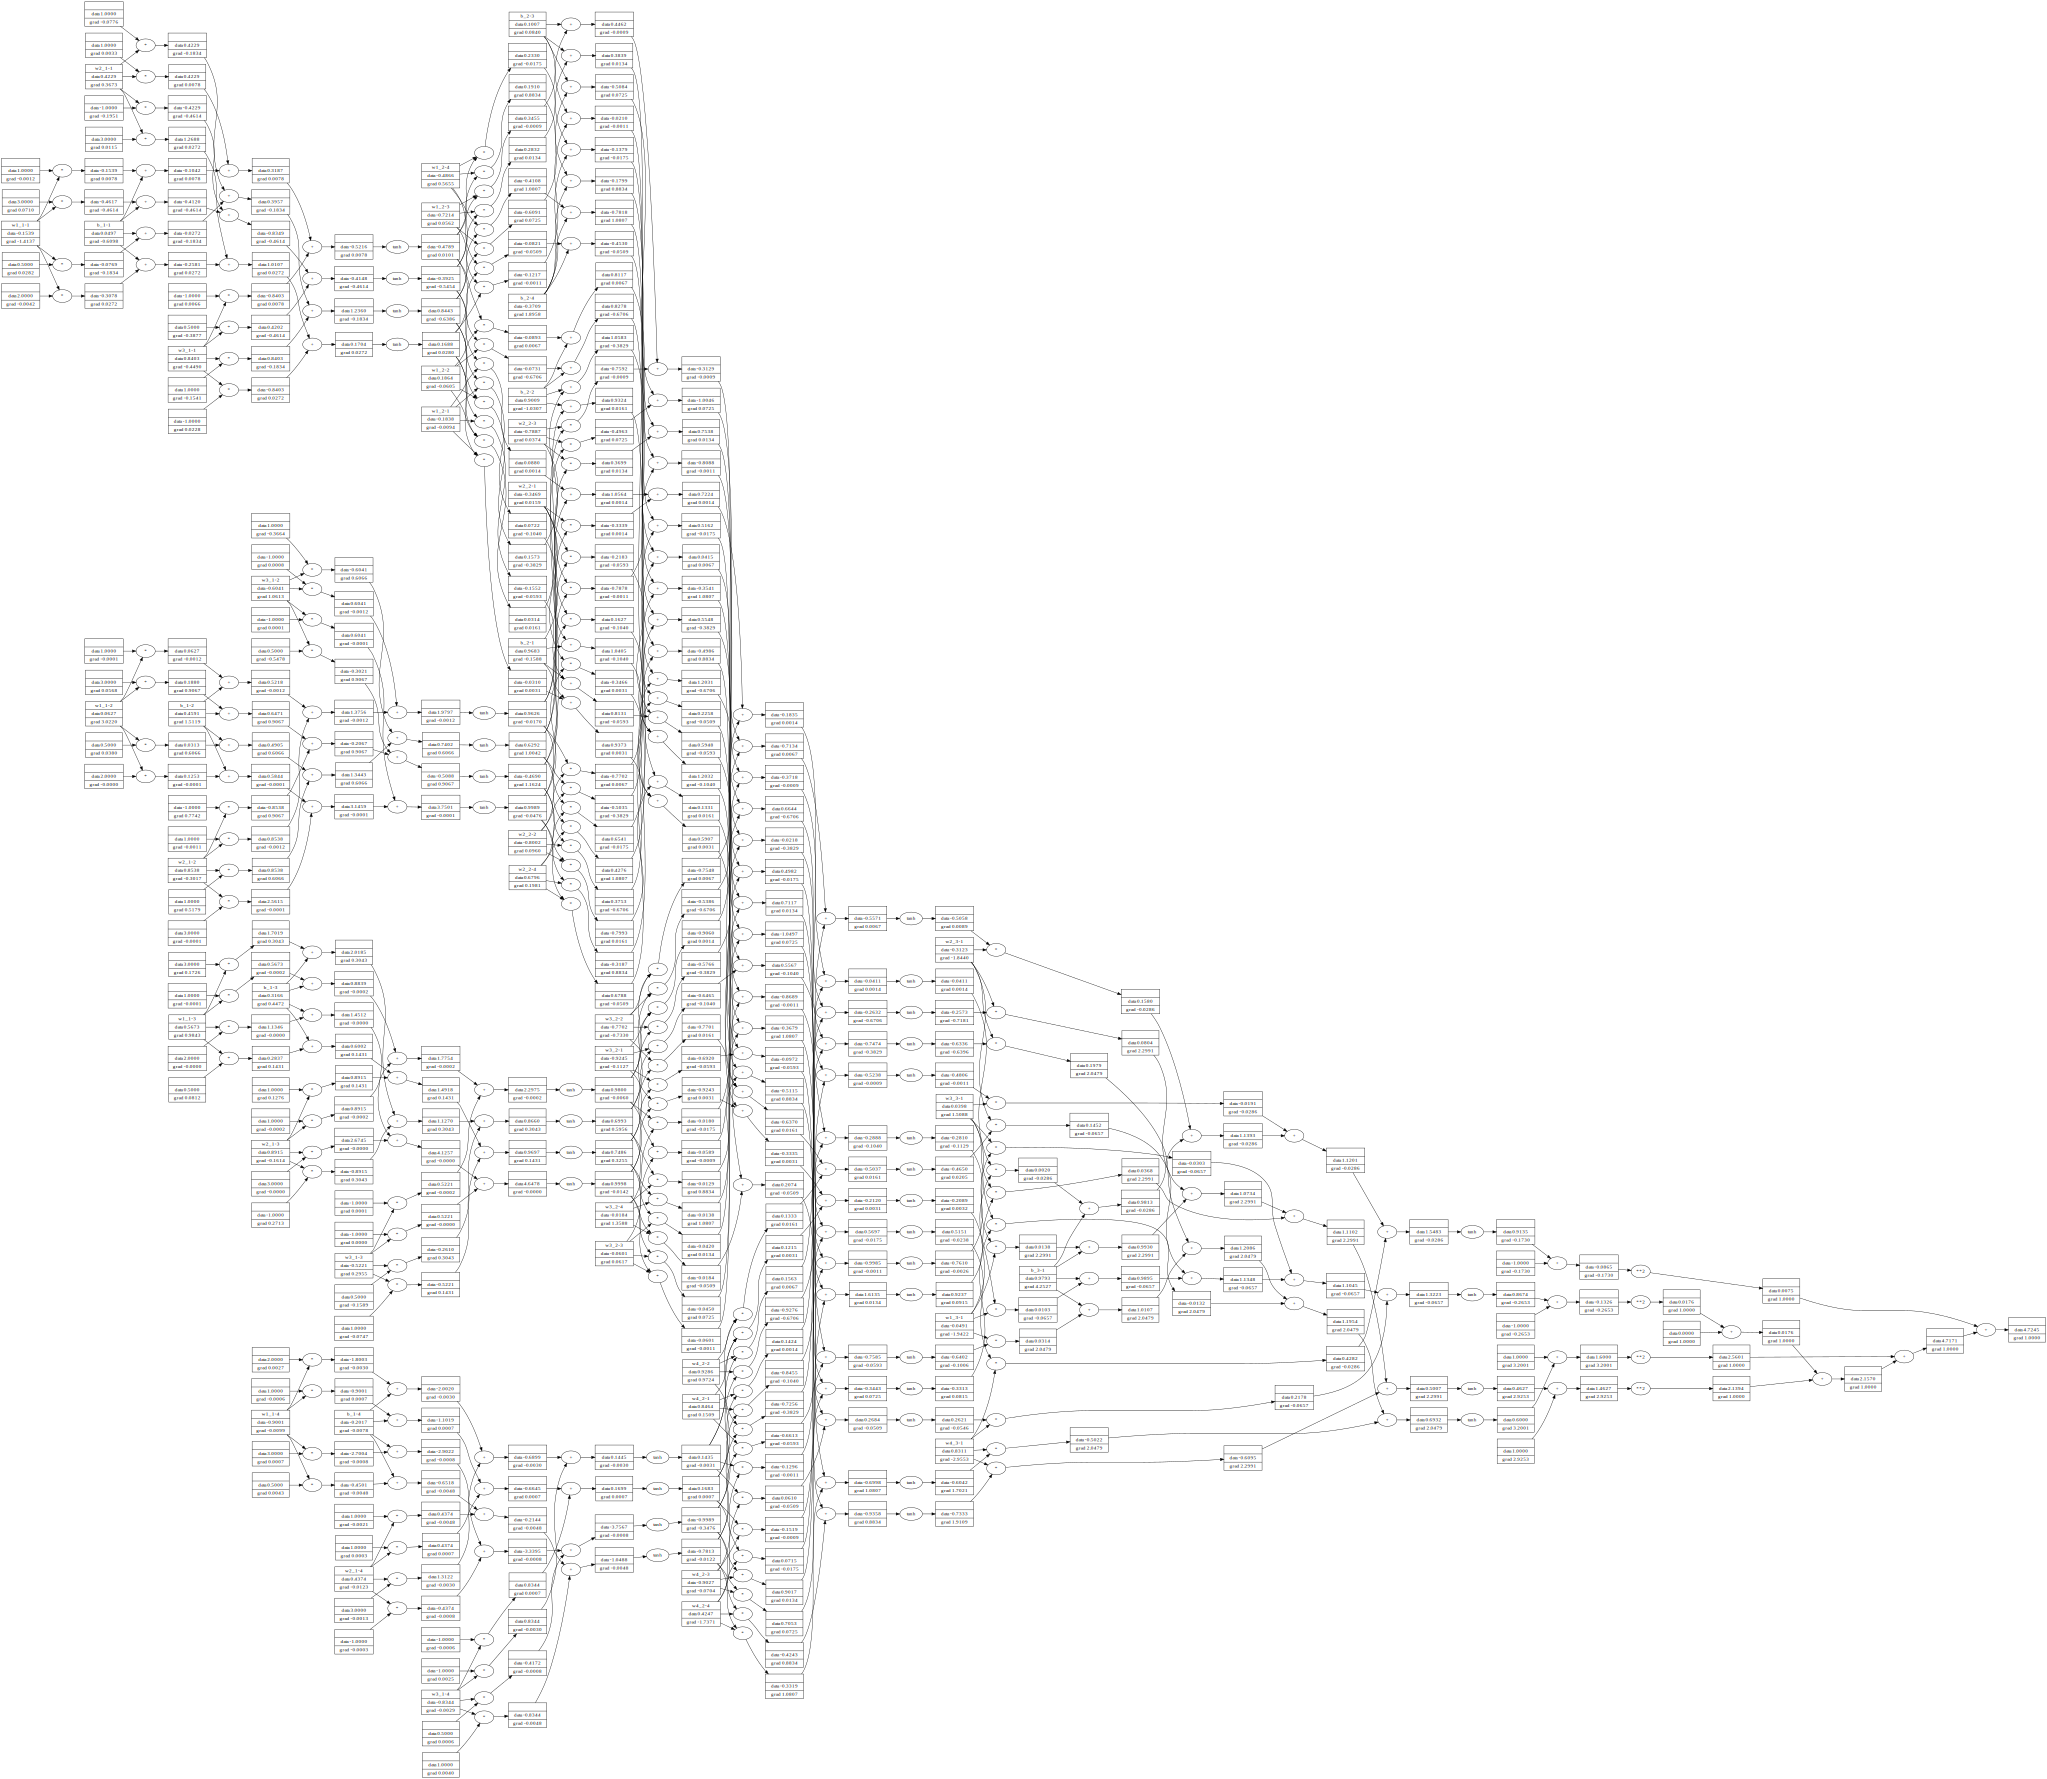

In [53]:
draw_dot(loss)

In [54]:
# Incerasing the data of params by a tiny amount of the grad, loss should go down
for p in n.parameters():
    p.data += -0.01 * p.grad

In [55]:
n.layers[0].neurons[0].w[0]

Vw1_1-1[d:-0.139762 | grad:-1.4136807156566729]

In [56]:
yprod, loss = calc_loss(n, xs, ys)

In [57]:
yprod

[V[d:0.847686 | grad:0],
 V[d:0.322204 | grad:0],
 V[d:0.515714 | grad:0],
 V[d:0.903596 | grad:0]]

In [58]:
loss

V[d:4.078105 | grad:0]

In [59]:
#Again
for p in n.parameters():
    p.grad = 0.0
loss.backward()
for p in n.parameters():
    p.data += -0.01 * p.grad
yprod, loss = calc_loss(n, xs, ys)
print(yprod)
print(loss)

[V[d:0.825394 | grad:0], V[d:0.177557 | grad:0], V[d:0.418476 | grad:0], V[d:0.892900 | grad:0]]
V[d:3.440674 | grad:0]


In [60]:
# continue to iterate the step above...
# these will be the final params:
n.parameters()

[Vw1_1-1[d:-0.126302 | grad:-1.346094945509801],
 Vw2_1-1[d:0.415426 | grad:0.38359329208076365],
 Vw3_1-1[d:0.849373 | grad:-0.45463834605436576],
 Vb_1-1[d:0.061636 | grad:-0.5829664326557896],
 Vw1_1-2[d:0.006321 | grad:2.6117689850666532],
 Vw2_1-2[d:0.857712 | grad:-0.08665391968103278],
 Vw3_1-2[d:-0.625294 | grad:1.055686174693777],
 Vb_1-2[d:0.429695 | grad:1.4313913893975965],
 Vw1_1-3[d:0.547797 | grad:0.9664981559850867],
 Vw2_1-3[d:0.894704 | grad:-0.1587043228352358],
 Vw3_1-3[d:-0.527955 | grad:0.2900961390659815],
 Vb_1-3[d:0.307735 | grad:0.4390092311653979],
 Vw1_1-4[d:-0.899893 | grad:-0.01573590036675937],
 Vw2_1-4[d:0.437660 | grad:-0.015272494801082614],
 Vw3_1-4[d:-0.834605 | grad:0.024493743169839568],
 Vb_1-4[d:-0.201649 | grad:0.002209591032886656],
 Vw1_2-1[d:-0.183637 | grad:-0.01086915320200073],
 Vw2_2-1[d:-0.347255 | grad:0.015991704340035866],
 Vw3_2-1[d:-0.922614 | grad:-0.07113003613278862],
 Vw4_2-1[d:0.843907 | grad:0.09773459025943497],
 Vb_2-1[d:0.9

In [69]:
# in summary:

for k in range(1000):
    
#     forward pass
    yprod = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, yprod))
    
#     backward pass
    for p in n.parameters():
        p.grad = 0 # remember to zero grads!! 
    loss.backward()
    
#     update
    for p in n.parameters():
        p.data += -0.01 * p.grad
    
    print(k, loss.data)

0 0.029384629741413267
1 0.02910697033524627
2 0.028834248796382342
3 0.028566337623887786
4 0.0283031136051215
5 0.028044457638815395
6 0.027790254566772282
7 0.027540393013699614
8 0.02729476523472594
9 0.027053266970176144
10 0.026815797307209184
11 0.02658225854794387
12 0.026352556083723746
13 0.026126598275191572
14 0.02590429633786527
15 0.025685564232923903
16 0.025470318562932404
17 0.025258478472245424
18 0.025049965551851596
19 0.024844703748428145
20 0.024642619277391933
21 0.02444364053974573
22 0.024247698042527587
23 0.02405472432268424
24 0.02386465387419911
25 0.023677423078314157
26 0.023492970136694238
27 0.023311235007391712
28 0.023132159343475404
29 0.022955686434196758
30 0.022781761148572083
31 0.02261032988126689
32 0.022441340500673174
33 0.02227474229907877
34 0.022110485944830192
35 0.02194852343639815
36 0.021788808058257347
37 0.02163129433849944
38 0.02147593800809955
39 0.021322695961762138
40 0.021171526220276234
41 0.021022387894312287
42 0.02087524114

382 0.005908302176617541
383 0.0058953870784252465
384 0.005882526347072217
385 0.005869719644714548
386 0.005856966636279794
387 0.005844266989438849
388 0.0058316203745781715
389 0.005819026464771998
390 0.005806484935755326
391 0.005793995465897031
392 0.005781557736173265
393 0.005769171430141281
394 0.005756836233913382
395 0.005744551836131565
396 0.005732317927941988
397 0.005720134202970121
398 0.00570800035729594
399 0.005695916089429623
400 0.005683881100287344
401 0.005671895093167489
402 0.005659957773727209
403 0.005648068849958946
404 0.005636228032167529
405 0.005624435032947515
406 0.0056126895671606315
407 0.005600991351913646
408 0.005589340106536392
409 0.005577735552560095
410 0.005566177413695941
411 0.005554665415813922
412 0.005543199286921855
413 0.005531778757144691
414 0.005520403558704152
415 0.005509073425898368
416 0.005497788095082067
417 0.0054865473046465905
418 0.005475350795000553
419 0.005464198308550536
420 0.005453089589681867
421 0.0054420243847398

758 0.0032061464789558485
759 0.0032021787109172317
760 0.003198220429847392
761 0.0031942716021805366
762 0.0031903321945079294
763 0.003186402173577036
764 0.0031824815062906388
765 0.0031785701597058535
766 0.0031746681010332792
767 0.0031707752976361096
768 0.003166891717029265
769 0.0031630173268784815
770 0.003159152094999421
771 0.0031552959893569443
772 0.0031514489780639955
773 0.0031476110293810365
774 0.003143782111715019
775 0.0031399621936185743
776 0.003136151243789225
777 0.003132349231068514
778 0.0031285561244411607
779 0.0031247718930343367
780 0.003120996506116739
781 0.003117229933097861
782 0.0031134721435271667
783 0.0031097231070932644
784 0.0031059827936231674
785 0.0031022511730814787
786 0.0030985282155696005
787 0.003094813891325029
788 0.003091108170720466
789 0.00308741102426315
790 0.0030837224225940775
791 0.003080042336487233
792 0.003076370736848825
793 0.0030727075947166093
794 0.003069052881259041
795 0.003065406567774648
796 0.0030617686256912548
797

In [70]:
yprod

[V[d:0.981631 | grad:-0.036738400086834266],
 V[d:-0.978531 | grad:0.04293755438788005],
 V[d:-0.967061 | grad:0.06587720122574914],
 V[d:0.975906 | grad:-0.04818836416675554]]